In [5]:
!pip install mne
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.9 MB/s eta 0:00:00


In [6]:
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import scipy.io as sio
from scipy.signal import periodogram
import neurokit2 as nk
import pywt
from collections import Counter
from tqdm.notebook import tqdm
import scipy.stats as stats

nSamples = 8000 #number of samples per segment
fs = 400 #sampling rate
wavelet_name = 'db1' # name of discrete mother wavelet used in Discrete Wavelet Transform

In [85]:
# Iterate over the list of signals and for each signal:
# - Extract 16 statistical features from the raw EEG signal (nonlinear energy, line length, entropy, etc.)
# - Extract the power in each of the 5 major frequency bands from the raw EEG signal
# - Extract 156 statistical features from the DWT coefficients of the EEG signal by doing the following:
#     - Apply the DWT which returns 13 lists of coefficients.
#     - For each of these lists extract 12 statistical features.
#     - The features calculated from all of the lists of coefficients belonging to one signal
#     - are concatenated together, since they belong to the same signal.

def get_features(list_signals, waveletname):
    list_features = []
    for signal in tqdm(list_signals):
        time_features = get_time_features(signal)
        freq_features = get_freq_features(signal)
        dwt_coeff = get_dwt_coeff(signal, waveletname)
        features = []
        for coeff in dwt_coeff:
            features += get_time_freq_features(coeff)
        for ff in freq_features:
            features.append(ff)
        for tf in time_features:
            features.append(tf)
        list_features.append(features)
    return np.array(list_features, dtype=object)

In [75]:
# Return list of statistical features from data: time-domain features
def get_time_features(data,fs=fs,nSamples=nSamples):
    result = get_time_freq_features(data)
    result.append(nonlinear_energy(data))
    result.append(line_length(data))
    f, psd = periodogram(data, fs)
    result.append(IWMF(f, psd))
    result.append(IWBW(f, psd))
    return result

In [76]:
# Return list of power band values from data: frequency-domain features
def get_freq_features(data, fs=fs):
  power_bands = nk.eeg_power(data, frequency_band=['Gamma', 'Beta', 'Alpha', 'Theta', 'Delta'], sampling_rate=fs)
  band_power = power_bands.values.tolist()[0][1:]
  return band_power

In [77]:
# Return list of Discrete Wavelet Transform coefficients from data
def get_dwt_coeff(data, waveletname):
  return pywt.wavedec(data, waveletname)

In [78]:
# Return list of simple statistical features from data
def get_time_freq_features(data):
    entropy = calculate_entropy(data)
    crossings = calculate_crossings(data)
    statistics = calculate_statistics(data)
    return [entropy] + crossings + statistics

In [79]:
# Return the nonlinear energy from data
def nonlinear_energy(X):
    return sum(X[1:-1]**2 - X[2:]*X[:-2])

In [80]:
# Return the line length from data
def line_length(X):
    return sum(np.abs(X[:-1]-X[1:]))

In [81]:
# Return the intensity weighted mean frequency (IWMF) from data
def IWMF(F,PSD):
    nPSD = PSD /sum(PSD)
    iwmf = np.dot(PSD,F)
    return iwmf

In [82]:
# Return the intensity weighted bandwidth (IWBW) from data
def IWBW(F, PSD):
    nPSD = PSD /sum(PSD)
    iwmf = IWMF(F, PSD)
    iwbw = np.sqrt(np.mean(((nPSD*(F-iwmf))**2)))
    return iwbw

In [21]:
# Return the entropy from list of values
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=sp.stats.entropy(probabilities)
    return entropy

In [22]:
# Return simple statistical features from list of values
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

In [23]:
# Return the number of zero crossings and mean crossings from list of values
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    number_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    number_mean_crossings = len(mean_crossing_indices)
    return [number_zero_crossings, number_mean_crossings]

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extracting EDF parameters from /content/drive/Shareddrives/BE_223A_Seizure_Project/aaaaaajy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7999  =      0.000 ...    19.997 secs...
Using matplotlib as 2D backend.


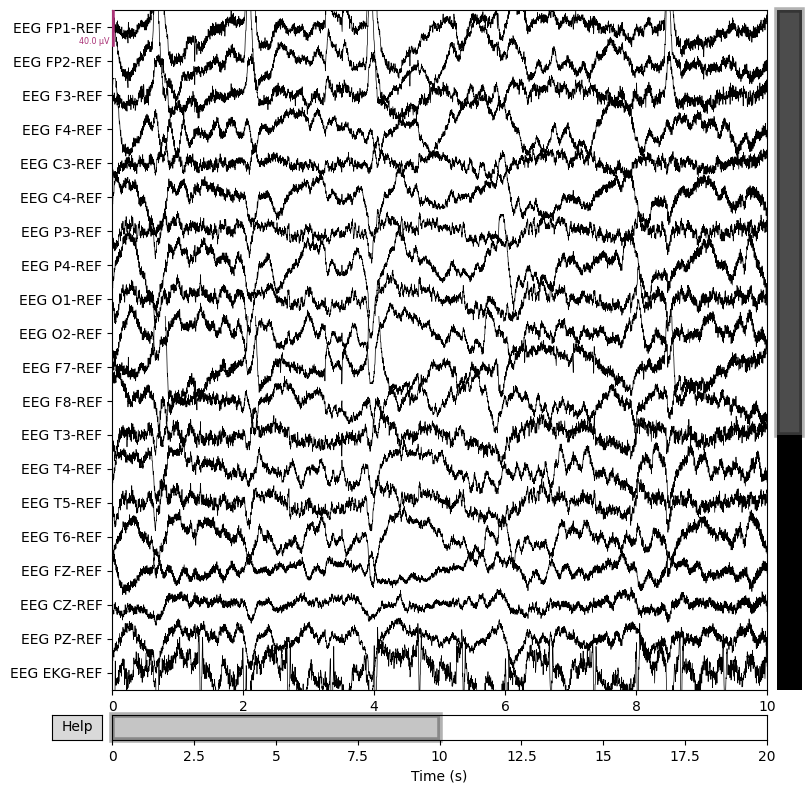

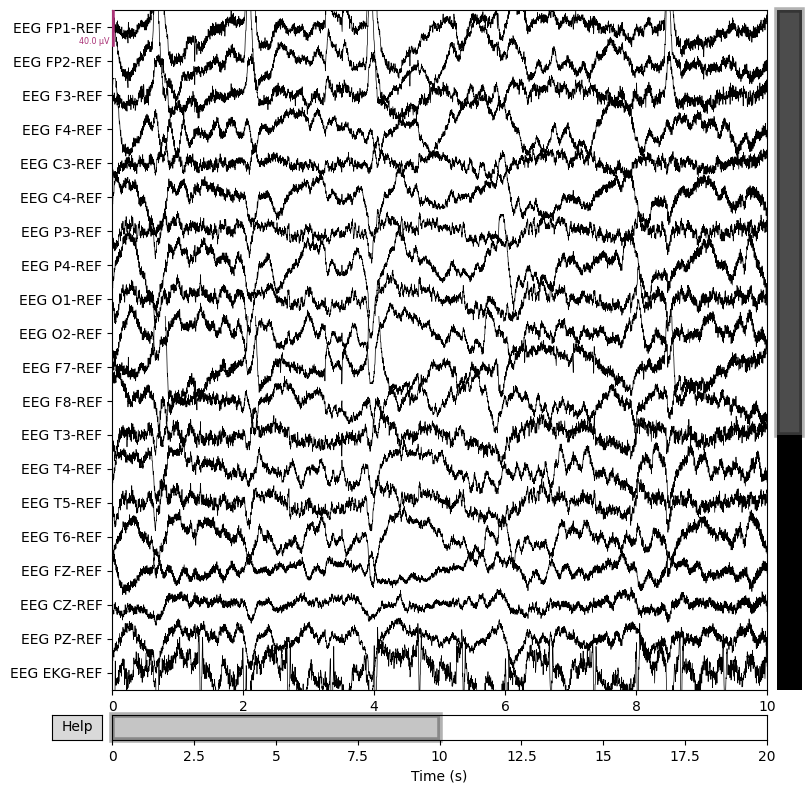

In [9]:
edf_data = mne.io.read_raw_edf('/content/drive/Shareddrives/BE_223A_Seizure_Project/aaaaaajy_s002_t000.edf', preload=True)
edf_data.plot()

In [10]:
multichannel_data, time = edf_data[:, :]
print(multichannel_data.shape, time.shape)

(32, 8000) (8000,)


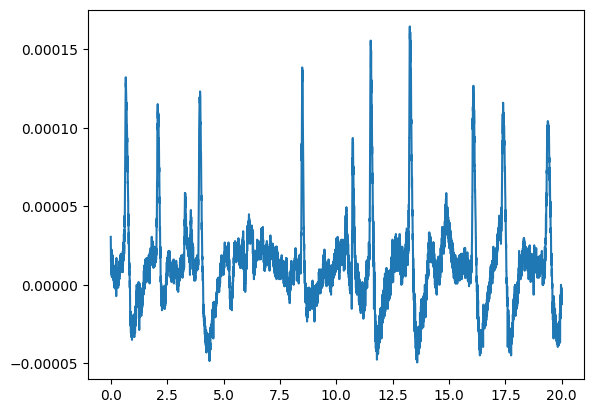

In [11]:
plt.plot(time, multichannel_data[0])

In [86]:
features = get_features(multichannel_data, 'db1')

  0%|          | 0/32 [00:00<?, ?it/s]

In [87]:
features.shape

(32, 177)

In [88]:
# Test the get_features function by asserting it outputs a matrix with the right dimensions
def eval_get_features(list_signals, wavelet_name):
  features = get_features(list_signals, wavelet_name)
  print('The features matrix has dimensions ' + str(features.shape))
  if features.shape == (32, 177):
    print('Those are the correct dimensions!')
  if features.shape != (32, 177):
    print('Those are the wrong dimensions! The correct dimensions are (32, 177)')

In [89]:
eval_get_features(multichannel_data, wavelet_name)

  0%|          | 0/32 [00:00<?, ?it/s]

The features matrix has dimensions (32, 177)
Those are the correct dimensions!


In [ ]:
%cd  /content/gdrive/Shareddrives/BE_223A_Seizure_Project/Code/

from get_features import *
features = get_features(list_signals, wavelet_name)

[Errno 2] No such file or directory: '/content/gdrive/Shareddrives/BE_223A_Seizure_Project/Code/'
/content


ModuleNotFoundError: ignored